In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

Multiple Linear Regression: How do access to drinking water, electricity, and literacy rates predict poverty levels?

In [19]:
# Load datasets
environmental_indicators = pd.read_csv('environmental_indicators.csv')
social_indicators = pd.read_csv('social_indicators.csv')

In [21]:
# Merge datasets based on common identifiers (country/region and year)
# Adjust the merge keys based on your actual dataset structure
merged_data = pd.merge(social_indicators, environmental_indicators,
                       on=['country_code', 'year'], how='inner')

In [26]:
# Print the column names of merged_data to verify their correctness
print(merged_data.columns)

# Display a few rows of merged_data to understand its structure
print(merged_data.head())

Index(['country_code', 'year', 'LifeExpectancy_Female', 'LifeExpectancy_Male',
       'LifeExpectancy_Total', 'LiteracyRate_AdultTotal',
       'LiteracyRate_YouthTotal', 'Multidim_PovertyHeadcountRatio_UNDP',
       'Multidim_PovertyHeadcountRatio_WorldBank',
       'Water_BasicDrinkingServices_PercentofPop',
       'Water_SafelyManagedDrinkingServices_PercentofPop',
       'Water_BasicHandwashing_PercentofPop',
       'Poverty_HeadcountRatio_NationalPovertyLines_Percent',
       'Poverty_HeadcountRatio_SocietalPovertyLines_Percent',
       'Unemployment_AdvancedEducation_Percent',
       'Unemployment_BasicEducation_Percent',
       'Unemployment_IntermediateEducation_Percent',
       'Unemployment_Total_Percent', 'Unemployment_YouthTotal_Percent',
       'MortalityRate_Air', 'MortalityRate_Poisoning',
       'MortalityRate_WaterHygiene', 'ElectricityAccess_PercentofPopulation',
       'CO2Emissions_Agriculture', 'CO2Emissions_TransportEnergy',
       'CO2Emissions_Waste', 'ForestAre

In [27]:
analysis_data = merged_data[['country_code', 'year','LiteracyRate_AdultTotal',
       'LiteracyRate_YouthTotal', 'Multidim_PovertyHeadcountRatio_UNDP',
       'Multidim_PovertyHeadcountRatio_WorldBank',
       'Water_BasicDrinkingServices_PercentofPop',
       'Water_SafelyManagedDrinkingServices_PercentofPop',
       'Water_BasicHandwashing_PercentofPop',
       'Poverty_HeadcountRatio_NationalPovertyLines_Percent',
       'Poverty_HeadcountRatio_SocietalPovertyLines_Percent',
       'Unemployment_AdvancedEducation_Percent',
       'Unemployment_BasicEducation_Percent',
       'Unemployment_IntermediateEducation_Percent',
       'Unemployment_Total_Percent', 'Unemployment_YouthTotal_Percent',
       'MortalityRate_WaterHygiene', 'ElectricityAccess_PercentofPopulation',]]

In [28]:
# Check for missing values
print("Missing values in each column:")
print(analysis_data.isnull().sum())

Missing values in each column:
country_code                                              0
year                                                      0
LiteracyRate_AdultTotal                                 902
LiteracyRate_YouthTotal                                 867
Multidim_PovertyHeadcountRatio_UNDP                    1049
Multidim_PovertyHeadcountRatio_WorldBank                876
Water_BasicDrinkingServices_PercentofPop                288
Water_SafelyManagedDrinkingServices_PercentofPop        544
Water_BasicHandwashing_PercentofPop                     745
Poverty_HeadcountRatio_NationalPovertyLines_Percent     865
Poverty_HeadcountRatio_SocietalPovertyLines_Percent     840
Unemployment_AdvancedEducation_Percent                  559
Unemployment_BasicEducation_Percent                     553
Unemployment_IntermediateEducation_Percent              553
Unemployment_Total_Percent                              500
Unemployment_YouthTotal_Percent                         510
Mortality

In [35]:
# Display the shape and missing values before cleaning
print(f"Total rows in dataset: {len(analysis_data)}")
print("\nMissing values in each column:")
print(analysis_data.isnull().sum())
print("\nPercentage of missing values:")
print(analysis_data.isnull().mean() * 100)

Total rows in dataset: 1085

Missing values in each column:
country_code                                              0
year                                                      0
LiteracyRate_AdultTotal                                 902
LiteracyRate_YouthTotal                                 867
Multidim_PovertyHeadcountRatio_UNDP                    1049
Multidim_PovertyHeadcountRatio_WorldBank                876
Water_BasicDrinkingServices_PercentofPop                288
Water_SafelyManagedDrinkingServices_PercentofPop        544
Water_BasicHandwashing_PercentofPop                     745
Poverty_HeadcountRatio_NationalPovertyLines_Percent     865
Poverty_HeadcountRatio_SocietalPovertyLines_Percent     840
Unemployment_AdvancedEducation_Percent                  559
Unemployment_BasicEducation_Percent                     553
Unemployment_IntermediateEducation_Percent              553
Unemployment_Total_Percent                              500
Unemployment_YouthTotal_Percent         

In [36]:
# Create a copy of the original data for imputation
analysis_data_filled = analysis_data.copy()

In [37]:
# Step 1: Forward-backward fill by country (for time series data)
# Sort by country and year before applying forward-backward fill
analysis_data_filled = analysis_data_filled.sort_values(['country_code', 'year'])
analysis_data_filled = analysis_data_filled.groupby('country_code').apply(
    lambda group: group.ffill().bfill()
).reset_index(drop=True)

<ipython-input-37-741037f7754f>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analysis_data_filled = analysis_data_filled.groupby('country_code').apply(


In [44]:
# Step 2: For remaining missing values, use KNN imputation
# Import KNNImputer
from sklearn.impute import KNNImputer # Importing the KNNImputer class

# First for our dependent variable
poverty_vars = ['Multidim_PovertyHeadcountRatio_UNDP']
# Then for our independent variables
indep_vars = ['Water_BasicDrinkingServices_PercentofPop',
              'ElectricityAccess_PercentofPopulation',
              'LiteracyRate_AdultTotal']

# Function to perform grouped KNN imputation
def group_knn_impute(data, variables, n_neighbors=5):
    if not variables:
        return data

    if len(data) <= n_neighbors:
        print(f"Warning: Dataset has fewer rows ({len(data)}) than n_neighbors ({n_neighbors})")
        n_neighbors = max(1, len(data) - 1)

    # Extract just these variables
    subset = data[variables].copy()

    # Skip imputation if all values are missing in a row
    if subset.isnull().all(axis=1).any():
        print(f"Warning: Some rows have all missing values for {variables}")

    # Apply KNN imputation
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_subset = imputer.fit_transform(subset)

    # Replace values in the original data
    data[variables] = imputed_subset
    return data

# Apply imputation to dependent and independent variables
analysis_data_filled = group_knn_impute(analysis_data_filled, poverty_vars)
analysis_data_filled = group_knn_impute(analysis_data_filled, indep_vars)

In [45]:
# Step 3: For any remaining missing values, use median values
all_vars = poverty_vars + indep_vars
for col in all_vars:
    if analysis_data_filled[col].isnull().any():
        median_val = analysis_data_filled[col].median()
        analysis_data_filled[col] = analysis_data_filled[col].fillna(median_val)
        print(f"Filled remaining missing values in {col} with median: {median_val}")

# Final check for missing values
print("\nMissing values after complete imputation:")
print(analysis_data_filled.isnull().sum())


Missing values after complete imputation:
country_code                                             0
year                                                     0
LiteracyRate_AdultTotal                                  0
LiteracyRate_YouthTotal                                405
Multidim_PovertyHeadcountRatio_UNDP                      0
Multidim_PovertyHeadcountRatio_WorldBank               605
Water_BasicDrinkingServices_PercentofPop                 0
Water_SafelyManagedDrinkingServices_PercentofPop       400
Water_BasicHandwashing_PercentofPop                    625
Poverty_HeadcountRatio_NationalPovertyLines_Percent    625
Poverty_HeadcountRatio_SocietalPovertyLines_Percent    545
Unemployment_AdvancedEducation_Percent                 310
Unemployment_BasicEducation_Percent                    315
Unemployment_IntermediateEducation_Percent             305
Unemployment_Total_Percent                             265
Unemployment_YouthTotal_Percent                        270
MortalityRate

In [46]:
# Use this cleaned dataset for analysis
clean_data = analysis_data_filled

# Save this cleaned version for future use
clean_data.to_csv('cleaned_poverty_analysis_data.csv', index=False)

In [47]:
# Exploratory data analysis
# Correlation matrix
correlation_matrix = clean_data[['LiteracyRate_AdultTotal',
       'LiteracyRate_YouthTotal', 'Multidim_PovertyHeadcountRatio_UNDP',
       'Multidim_PovertyHeadcountRatio_WorldBank',
       'Water_BasicDrinkingServices_PercentofPop',
       'Water_SafelyManagedDrinkingServices_PercentofPop',
       'Water_BasicHandwashing_PercentofPop',
       'Poverty_HeadcountRatio_NationalPovertyLines_Percent',
       'Poverty_HeadcountRatio_SocietalPovertyLines_Percent',
       'Unemployment_AdvancedEducation_Percent',
       'Unemployment_BasicEducation_Percent',
       'Unemployment_IntermediateEducation_Percent',
       'Unemployment_Total_Percent', 'Unemployment_YouthTotal_Percent',
       'MortalityRate_WaterHygiene', 'ElectricityAccess_PercentofPopulation']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                                                    LiteracyRate_AdultTotal  \
LiteracyRate_AdultTotal                                            1.000000   
LiteracyRate_YouthTotal                                            0.913881   
Multidim_PovertyHeadcountRatio_UNDP                               -0.399680   
Multidim_PovertyHeadcountRatio_WorldBank                          -0.730941   
Water_BasicDrinkingServices_PercentofPop                           0.755237   
Water_SafelyManagedDrinkingServices_PercentofPop                   0.679636   
Water_BasicHandwashing_PercentofPop                                0.688089   
Poverty_HeadcountRatio_NationalPovertyLines_Per...                -0.620694   
Poverty_HeadcountRatio_SocietalPovertyLines_Per...                -0.616683   
Unemployment_AdvancedEducation_Percent                            -0.353016   
Unemployment_BasicEducation_Percent                                0.239492   
Unemployment_IntermediateEducat

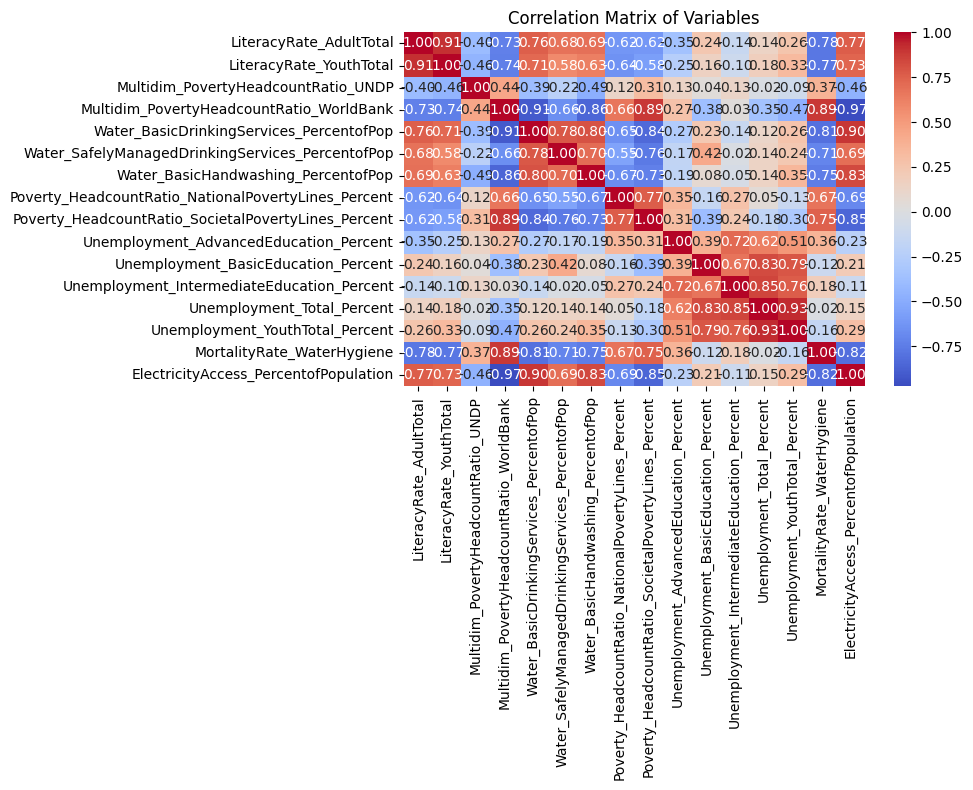

In [48]:
# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Variables')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

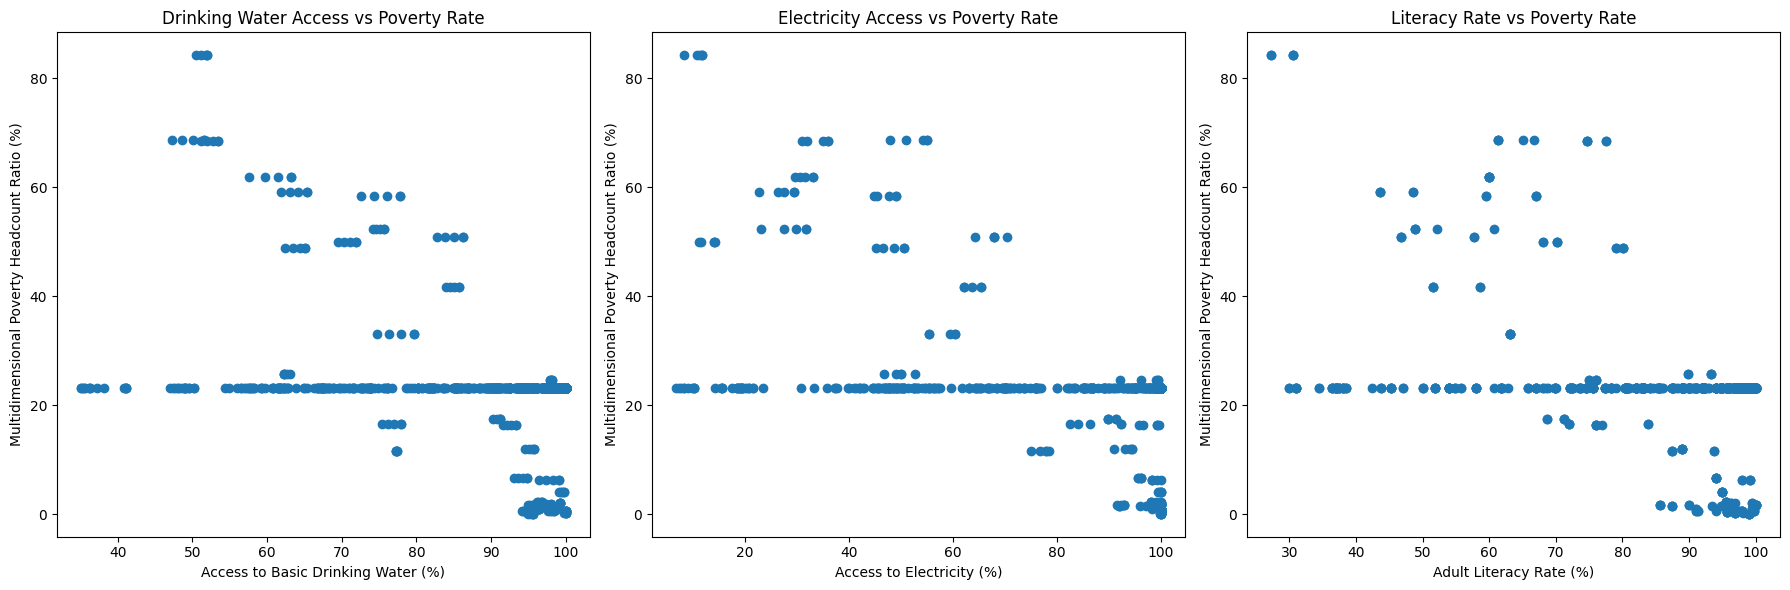

In [49]:
# Scatter plots to visualize relationships
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].scatter(clean_data['Water_BasicDrinkingServices_PercentofPop'],
                clean_data['Multidim_PovertyHeadcountRatio_UNDP'])
axes[0].set_xlabel('Access to Basic Drinking Water (%)')
axes[0].set_ylabel('Multidimensional Poverty Headcount Ratio (%)')
axes[0].set_title('Drinking Water Access vs Poverty Rate')

axes[1].scatter(clean_data['ElectricityAccess_PercentofPopulation'],
                clean_data['Multidim_PovertyHeadcountRatio_UNDP'])
axes[1].set_xlabel('Access to Electricity (%)')
axes[1].set_ylabel('Multidimensional Poverty Headcount Ratio (%)')
axes[1].set_title('Electricity Access vs Poverty Rate')

axes[2].scatter(clean_data['LiteracyRate_AdultTotal'],
                clean_data['Multidim_PovertyHeadcountRatio_UNDP'])
axes[2].set_xlabel('Adult Literacy Rate (%)')
axes[2].set_ylabel('Multidimensional Poverty Headcount Ratio (%)')
axes[2].set_title('Literacy Rate vs Poverty Rate')

plt.tight_layout()
plt.savefig('scatter_plots.png')
plt.show()

In [50]:
# Prepare data for regression
X = clean_data[['Water_BasicDrinkingServices_PercentofPop',
                'ElectricityAccess_PercentofPopulation',
                'LiteracyRate_AdultTotal']]
y = clean_data['Multidim_PovertyHeadcountRatio_UNDP']

In [51]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# Multiple linear regression using sklearn
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

LinearRegression()

In [54]:
# Make predictions
y_pred = reg_model.predict(X_test)

In [55]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")


Model Evaluation:
Mean Squared Error: 114.9235
R-squared: 0.1645


In [56]:
# Display coefficients
print("\nCoefficients:")
print(f"Intercept: {reg_model.intercept_:.4f}")
for i, col in enumerate(X.columns):
    print(f"{col}: {reg_model.coef_[i]:.4f}")


Coefficients:
Intercept: 35.4824
Water_BasicDrinkingServices_PercentofPop: 0.2075
ElectricityAccess_PercentofPopulation: -0.2704
LiteracyRate_AdultTotal: -0.0855


In [57]:
# Using statsmodels for more detailed statistical analysis
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
print("\nDetailed Statistical Results:")
print(model.summary())


Detailed Statistical Results:
                                     OLS Regression Results                                    
Dep. Variable:     Multidim_PovertyHeadcountRatio_UNDP   R-squared:                       0.225
Model:                                             OLS   Adj. R-squared:                  0.223
Method:                                  Least Squares   F-statistic:                     104.7
Date:                                 Mon, 14 Apr 2025   Prob (F-statistic):           1.59e-59
Time:                                         04:07:15   Log-Likelihood:                -3941.0
No. Observations:                                 1085   AIC:                             7890.
Df Residuals:                                     1081   BIC:                             7910.
Df Model:                                            3                                         
Covariance Type:                             nonrobust                                         
         

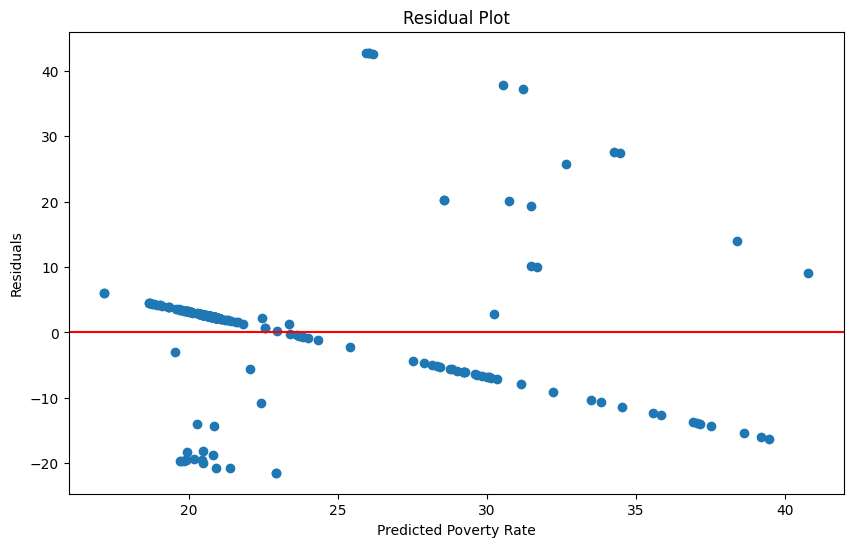

In [58]:
# Residual analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Poverty Rate')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.savefig('residual_plot.png')
plt.show()

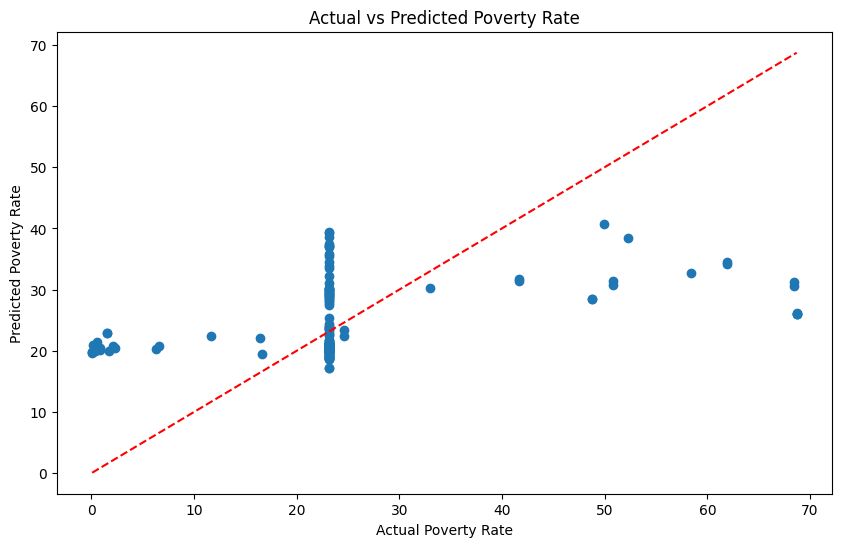

In [59]:
# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Poverty Rate')
plt.ylabel('Predicted Poverty Rate')
plt.title('Actual vs Predicted Poverty Rate')
plt.savefig('actual_vs_predicted.png')
plt.show()

In [60]:
# Analyze results by country/region for more insights
# Group by country and calculate averages to see patterns
country_analysis = clean_data.groupby('country_code').mean().reset_index()
country_analysis = country_analysis.sort_values('Multidim_PovertyHeadcountRatio_UNDP', ascending=True)

In [61]:
# Display top 10 countries with lowest and highest poverty rates
print("\nTop 10 Countries with Lowest Poverty Rates:")
print(country_analysis[['country_code', 'Multidim_PovertyHeadcountRatio_UNDP',
                       'Water_BasicDrinkingServices_PercentofPop',
                       'ElectricityAccess_PercentofPopulation',
                       'LiteracyRate_AdultTotal']].head(10))

print("\nTop 10 Countries with Highest Poverty Rates:")
print(country_analysis[['country_code', 'Multidim_PovertyHeadcountRatio_UNDP',
                       'Water_BasicDrinkingServices_PercentofPop',
                       'ElectricityAccess_PercentofPopulation',
                       'LiteracyRate_AdultTotal']].tail(10))


Top 10 Countries with Lowest Poverty Rates:
    country_code  Multidim_PovertyHeadcountRatio_UNDP  \
176          SRB                                  0.1   
192          TKM                                  0.2   
6            ARG                                  0.4   
190          THA                                  0.6   
161          PSE                                  0.6   
45           CUB                                  0.7   
185          SYC                                  0.9   
194          TON                                  0.9   
63           FJI                                  1.5   
204          UZB                                  1.7   

     Water_BasicDrinkingServices_PercentofPop  \
176                                 95.448765   
192                                 99.958585   
6                                   94.771441   
190                                 99.992966   
161                                 98.105438   
45                               

In [62]:
# Perform additional validation checks
# Check for multicollinearity using VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\nVariance Inflation Factors (check for multicollinearity):")
print(vif_data)


Variance Inflation Factors (check for multicollinearity):
                                   Variable         VIF
0  Water_BasicDrinkingServices_PercentofPop  100.976553
1     ElectricityAccess_PercentofPopulation   53.614674
2                   LiteracyRate_AdultTotal   68.192431


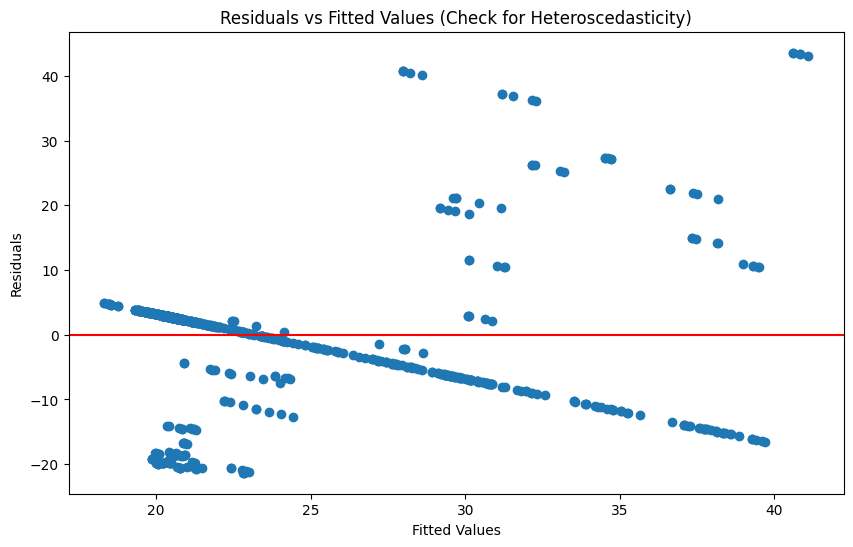

In [63]:
# Check for heteroscedasticity
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Check for Heteroscedasticity)')
plt.axhline(y=0, color='r', linestyle='-')
plt.savefig('heteroscedasticity_check.png')
plt.show()

In [64]:
# Save model results for further analysis or reporting
import pickle
with open('poverty_regression_model.pkl', 'wb') as file:
    pickle.dump(reg_model, file)

print("\nAnalysis complete. Model saved to 'poverty_regression_model.pkl'")


Analysis complete. Model saved to 'poverty_regression_model.pkl'


In [67]:
!jupyter nbconvert --to html /content/RQ1MLR.ipynb

[NbConvertApp] WARNING | pattern '/content/RQ1MLR.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute